<h1>Modeling 'churn'</h1>
<h3>
KDD Cup 2009: Customer relationship prediction</h3>
<p>Customer Relationship Management (CRM) is a key element of modern marketing strategies. The KDD Cup 2009 offers the opportunity to work on large marketing databases from the French Telecom company Orange to predict the propensity of customers to switch provider (churn), buy new products or services (appetency), or buy upgrades or add-ons proposed to them to make the sale more profitable (up-selling).

The most practical way, in a CRM system, to build knowledge on customer is to produce scores. A score (the output of a model) is an evaluation for all instances of a target variable to explain (i.e. churn, appetency or up-selling). Tools which produce scores allow to project, on a given population, quantifiable information. The score is computed using input variables which describe instances. Scores are then used by the information system (IS), for example, to personalize the customer relationship. An industrial customer analysis platform able to build prediction models with a very large number of input variables has been developed by Orange Labs. This platform implements several processing methods for instances and variables selection, prediction and indexation based on an efficient model combined with variable selection regularization and model averaging method. The main characteristic of this platform is its ability to scale on very large datasets with hundreds of thousands of instances and thousands of variables. The rapid and robust detection of the variables that have most contributed to the output prediction can be a key factor in a marketing application.

The challenge is to beat the in-house system developed by Orange Labs. It is an opportunity to prove that you can deal with a very large database, including heterogeneous noisy data (numerical and categorical variables), and unbalanced class distributions. Time efficiency is often a crucial point. Therefore part of the competition will be time-constrained to test the ability of the participants to deliver solutions quickly.</p>

In [1]:
'''
Importing everything I need.
'''
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
'''
Loading features
'''
features = pd.read_csv('D:/PROGRAMANDO/_DataStudy/Udemy_Kagle/kdd_coup_2009/kdd/orange_small_train.data', sep = '\t', na_filter = False)

In [3]:
features.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,,,,,,1526,7,,,,...,oslk,fXVEsaq,jySVZNlOJy,,,xb3V,RAYp,F2FyR07IdsN7I,,
1,,,,,,525,0,,,,...,oslk,2Kb5FSF,LM8l689qOp,,,fKCe,RAYp,F2FyR07IdsN7I,,
2,,,,,,5236,7,,,,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,
3,,,,,,,0,,,,...,oslk,CE7uk3u,LM8l689qOp,,,FSa2,RAYp,F2FyR07IdsN7I,,
4,,,,,,1029,7,,,,...,oslk,1J2cvxe,LM8l689qOp,,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,


In [4]:
'''
Loading the answers (outcome))
'''
outcome = pd.read_csv('D:/PROGRAMANDO/_DataStudy/Udemy_Kagle/kdd_coup_2009/kdd/orange_small_train_churn.labels', header = None)

In [5]:
outcome.head()

,0
0,-1
1,1
2,-1
3,-1
4,-1


In [6]:
'''
Returns all the unique values from outcome. It must have only 2 in this case.
'''

np.unique(outcome)

array([-1,  1], dtype=int64)

<h3>Identify categorical and numerical variables.</h3>

In [7]:
all_vars = np.array(features.columns)

In [8]:
'''
Only numerical values. As it was stated in the challenge, the first 190th are numerical variables. 
'''
num_vars = np.array(all_vars[:190])

In [9]:
'''
Only categorical variables. As it was stated in the challenge, beggining in 191th, all the variables until the end
are categorical'''

cat_vars = np.array(all_vars[190:])

<h3>Analysing the numerical variables.</h3>

In [10]:
features.shape

(50000, 230)

In [11]:
'''
We can see how many of each value we have at the column 'Var1'. We have 49298 empty values.
'''
var = features.groupby('Var1').size()
var

Var1
       49298
0        380
120        1
128        2
152        1
16        81
24        46
32        23
360        1
392        1
40        10
48         6
536        1
56         5
64         1
680        1
72         3
8        138
80         1
dtype: int64

<h3>Transforming the numerical and categorical columns.</h3>

In [12]:
'''
Here i am verifying all the values in all the numerical columns with a loop. 
We are looping through all the numerical variables and storing the quantity of unique values in each column 
in a variable called col_count. 
'''
counts_per_column = pd.DataFrame()
for col in num_vars:
    col_count = features.groupby(col).size()
    counts_per_column = counts_per_column.append(col_count, ignore_index = True)

In [13]:
counts_per_column.shape

(190, 351788)

In [14]:
counts_per_column.T.shape

(351788, 190)

In [15]:
'''
First we transform the 190 rows into columns, as it should be. 
'''

counts_per_column = counts_per_column.T
counts_per_column.index = counts_per_column.index.astype('str')
counts_per_column.sort_index(inplace = True)

#Here i have the first 10 columns in order. If there is a column with categorical values, it will appears in the 
#first positions.
print("Primeiras 10 categorias: ", counts_per_column.index[:10])

Primeiras 10 categorias:  Index(['', '-10', '-1000060.0', '-10002.16', '-100034.8', '-1000420.0',
       '-1000468.0', '-1000496.0', '-1000516.0', '-1000548.0'],
      dtype='object')


In [16]:
'''
Here i am verifying all the values in all the categorical columns with a loop. 
We are looping through all the categorical variables and storing the quantity of unique values in each column 
in a variable called col_count. 
'''
counts_per_column = pd.DataFrame()
for col in cat_vars:
    col_count = features.groupby(col).size()
    counts_per_column = counts_per_column.append(col_count, ignore_index = True)

In [17]:
counts_per_column = counts_per_column.T
counts_per_column.index = counts_per_column.index.astype('str')
counts_per_column.sort_index(inplace = True)
print('Primeiras dez categorias: ', counts_per_column.index[:10])
print('Últimas dez categorias: ', counts_per_column.index[(len(counts_per_column.index)-10):])

Primeiras dez categorias:  Index(['', '000J', '0062', '00AD', '00ARusu', '00AYONy', '00AhP4J', '00J8E9a',
       '00JHTSP', '00L3'],
      dtype='object')
Últimas dez categorias:  Index(['zzQ9udm', 'zzQV', 'zzbGOGx', 'zzbGa54', 'zzcv6yg4s3UGv', 'zzfHvGh',
       'zzfLM_S', 'zzfUfAI', 'zzfo6HG', 'zzpZ'],
      dtype='object')


<h3>Treating the missing values</h3>

In [18]:
'''
Replacing the empty spaces to 'nan', so that we can treat this problem in an easy way.
'''
features = features.replace('', np.nan)


In [19]:
'''
Here i am transforming the variable types. The numerical variables are gonna turn into 'float' and the 
categorical variables are gonna turn into 'category'
'''
#For numerical values
for col in num_vars:
    features[col] = features[col].astype('float')
    
#For categorical values
for col in cat_vars:
    features[col] = features[col].astype('category')

In [20]:
'''
Verifying how many empty entries each variable has
'''
empty_entry_per_column = features.isna().sum(axis = 0)

In [21]:
'''
We have too many empty values in some variables. We need to drop them.
'''

empty_entry_per_column.head()

Var1    49298
Var2    48759
Var3    48760
Var4    48421
Var5    48513
dtype: int64

(array([ 28.,  38.,   1.,   0.,   2.,   5.,   0.,   2.,   0., 154.]),
 array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.,
        40000., 45000., 50000.]),
 <a list of 10 Patch objects>)

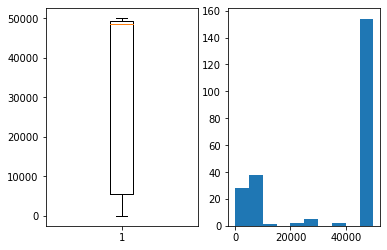

In [22]:
'''
Printing the boxplot and the historogram showing the empty entries per column
'''

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.boxplot(empty_entry_per_column)
ax2.hist(empty_entry_per_column)


In [23]:
'''
Printing the median from the empty_entry_per_column to compare with the graphics.
'''
median = empty_entry_per_column.median()
print(median)

48513.0


<h3>Conclusion about the missing values</h3>
<p>
    As we can see from the graphics, we have too many empty values. We have a little more than 48000 empty values in many variables. The boxplot shows this problem. 
    
   <p>Looking at the historigram, we can see that we have a little more than 40 variables with around 10000 missing values. It means that if we drop every variable with more than 10000 missing values, we are gonna be able to keep a low missing values in the dataframe.</p>
</p>

In [24]:
'''
The threshold is the percentage of acceptable missing values in each variable. 
'''
num_entries = len(features)
threshold = 0.25



In [25]:
'''
The 'keep_vars' represents the variables that we are gonna keep, under a condition: the empty entries per column must be
less than (threshold)% of the entire variable
'''
keep_vars = np.array(features.columns[(empty_entry_per_column <= (num_entries * threshold))])

In [26]:
keep_vars

array(['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25',
       'Var28', 'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var73',
       'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var109',
       'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var132',
       'Var133', 'Var134', 'Var140', 'Var143', 'Var144', 'Var149',
       'Var153', 'Var160', 'Var163', 'Var173', 'Var181', 'Var192',
       'Var193', 'Var195', 'Var196', 'Var197', 'Var198', 'Var199',
       'Var202', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207',
       'Var208', 'Var210', 'Var211', 'Var212', 'Var216', 'Var217',
       'Var218', 'Var219', 'Var220', 'Var221', 'Var222', 'Var223',
       'Var226', 'Var227', 'Var228'], dtype=object)

<h3>Updating the dataframes with numerical and categorical variables</h3>

In [27]:
'''
Here i am updating the dataframes that contains the numerical and the categorical values with the values whose 
missing values are below 0.25% the entire variable 
'''
num_vars = [elem for elem in num_vars if elem in keep_vars]
cat_vars = [elem for elem in cat_vars if elem in keep_vars]

In [28]:
'''
For the numerical variables, i am gonna replace the null values with the mean of the variable.
'''

for col in num_vars:
    col_mean = features[col].mean()
    features[col] = features[col].fillna(col_mean)

In [29]:
'''
For the categorical variables, i am gonna replace the null values with the word 'missing'.
'''

for col in cat_vars:
    features[col] = features[col].cat.add_categories('missing')
    features[col] = features[col].fillna('missing')

<h3>Eliminating variables with too many unique values.</h3>

In [30]:
'''
Let's group to verify how many different values (categories) each variable has.
The set method return only the unique values in order. The len(set()) method returns the quantity of unique values. 
'''
n_categories_per_feature = features[cat_vars].apply(lambda x: len(set(x)))

In [31]:
n_categories_per_feature

Var192      362
Var193       51
Var195       23
Var196        4
Var197      226
Var198     4291
Var199     5074
Var202     5714
Var203        6
Var204      100
Var205        4
Var206       22
Var207       14
Var208        3
Var210        6
Var211        2
Var212       81
Var216     2016
Var217    13991
Var218        3
Var219       23
Var220     4291
Var221        7
Var222     4291
Var223        5
Var226       23
Var227        7
Var228       30
dtype: int64

(array([21.,  1.,  0.,  4.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([2.00000e+00, 1.40090e+03, 2.79980e+03, 4.19870e+03, 5.59760e+03,
        6.99650e+03, 8.39540e+03, 9.79430e+03, 1.11932e+04, 1.25921e+04,
        1.39910e+04]),
 <a list of 10 Patch objects>)

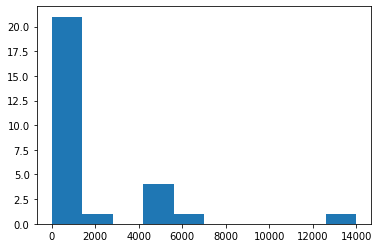

In [32]:
'''
As shown in the graphic below, there are about 21 variables with unique values above 1400. There are a few variables
with unique values above 5000 and even less, with unique values above 14000. So, we need to drop variables with too many 
unique values. In this case, above 1400. Otherwise, it's gonna be confusing to make some assumptions to our predictive model.
'''

plt.hist(n_categories_per_feature)

In [33]:
'''
In cat_vars we are gonna have only variables whose number of unique values is below 1400
'''
cat_vars = np.array(n_categories_per_feature[n_categories_per_feature < 1400].index)

In [34]:
cat_vars

array(['Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var203',
       'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210',
       'Var211', 'Var212', 'Var218', 'Var219', 'Var221', 'Var223',
       'Var226', 'Var227', 'Var228'], dtype=object)

In [35]:
'''
Putting the numerical and categorical variables in the same dataframe back again
'''
features = features[list(num_vars) + list(cat_vars)]

In [36]:
features.shape

(50000, 59)

In [37]:
features.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var210,Var211,Var212,Var218,Var219,Var221,Var223,Var226,Var227,Var228
0,1526.000000,7.0,184.0,464.000000,580.0,14.000000,128.0,166.56,0.0,3570.0,...,uKAI,L84s,XfqtO3UdzaXh_,cJvF,FzaX,oslk,jySVZNlOJy,xb3V,RAYp,F2FyR07IdsN7I
1,525.000000,0.0,0.0,168.000000,210.0,2.000000,24.0,353.52,0.0,4764966.0,...,uKAI,L84s,NhsEn4L,missing,FzaX,oslk,LM8l689qOp,fKCe,RAYp,F2FyR07IdsN7I
2,5236.000000,7.0,904.0,1212.000000,1515.0,26.000000,816.0,220.08,0.0,5883894.0,...,uKAI,L84s,UbxQ8lZ,UYBR,FzaX,Al6ZaUT,jySVZNlOJy,Qu4f,02N6s8f,ib5G6X1eUxUn6
3,1326.437116,0.0,0.0,234.518225,0.0,4.507926,0.0,22.08,0.0,0.0,...,uKAI,Mtgm,NhsEn4L,UYBR,FzaX,oslk,LM8l689qOp,FSa2,RAYp,F2FyR07IdsN7I
4,1029.000000,7.0,3216.0,64.000000,80.0,4.000000,64.0,200.00,0.0,0.0,...,uKAI,L84s,XfqtO3UdzaXh_,UYBR,FzaX,oslk,LM8l689qOp,FSa2,RAYp,F2FyR07IdsN7I


<h3>Selecting the adequate variables with decisions trees.</h3>
<p>We have many categorical and numerical variables. But we need to narrow down this quantity to more suitable variables. So that we can build a proper predictive model. In order to do that, we need to know how importante a variable is. We are gonna build a function to do that and put the variables in order of importance.
</p>

In [38]:
'''
Treating the categorical values, turning them into dummies
'''
features_churn = pd.get_dummies(features)

In [39]:
features_churn.shape

(50000, 1052)

In [40]:
'''
Explanation of the technique used below
'''
np.array(outcome).ravel()

array([-1,  1, -1, ..., -1, -1, -1], dtype=int64)

In [41]:
'''
We are creating a function that will return how important a variable is.
Outcome assumes the values -1 and 1
'''
def etc_importances(features, outcome):
    model = ExtraTreesClassifier(n_estimators = 200, criterion = 'entropy', verbose = 0 )
    model.fit(features, np.array(outcome).ravel())
    
    importances = model.feature_importances_
    variables = np.array(features.columns)
    indices = np.argsort(importances)[::-1]
    importances = importances[indices]
    variables = variables[indices]
    
    return variables, importances

In [42]:
variables, importances = etc_importances(features_churn, outcome)

In [43]:
features_churn.shape

(50000, 1052)

<h3>Discovering the ideal quantity of variables</h3>
<p>After the preprocessing, we have 1052. But we need to create a model with less variables.Otherwise the model will not perform very well. But how many variables do we need? That's what we are gonna find out. </p>

In [44]:
def sum_and_plot_importances(variables, importances):
    sum_importances = pd.DataFrame()
    for i in range(importances.size):
        sum_importance = importances[:(i+1)].sum()
        this_variable = pd.Series([variables[i], sum_importance])
        sum_importances = sum_importances.append(this_variable, ignore_index = True)
    plt.scatter(sum_importances.index, sum_importances.iloc[:,1])
    return sum_importances

<h3>Interpreting the importance graph</h3>
<p>
On the Y axis we have the level of importance that goes from zero to 1. On the X axis we have the indices of the variables. Note that in the graph that the importance curve stabilizes more or less at the 600 index. Therefore, as the indices are ordered, from this point on the variables do not have as much importance for the predictive model. And that is where we will cut.</p>

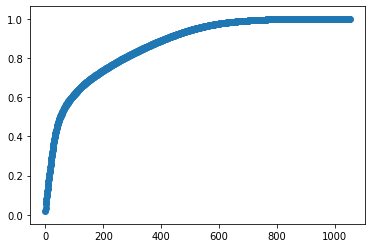

In [45]:
sum_importances = sum_and_plot_importances(variables, importances)

<h3>Removing undesired variables.</h3>
<p>
To facilitate the construction of the predictive model, we will build a dataframe that contains only variables whose importance is less than a certain threshold. Any variable whose limit is greater than this threshold, will be deleted from the new dataframe. A function called "keep_vars" will be created for this purpose.</p>

In [46]:
'''
Here we have the variables and their thresholds in the column '1'
'''
sum_importances

,0,1
0,Var57,0.018095
1,Var73,0.036016
2,Var113,0.053426
3,Var81,0.067191
4,Var153,0.080869
...,...,...
1047,Var226_missing,1.000000
1048,Var192_1JGr4RUaLY,1.000000
1049,Var204_missing,1.000000
1050,Var227_missing,1.000000


In [47]:
def keep_vars(features, sum_importances, threshold):
    keep_vars = list(sum_importances[sum_importances.iloc[:, 1] <= threshold].iloc[:, 0])
    features = features.loc[:, keep_vars]
    
    return features

In [48]:
features_churn = keep_vars(features_churn, sum_importances, threshold = 0.99)

<h3>After the preprocessing, we have our final dataframe down below. </h3>

In [49]:

features_churn.shape

(50000, 684)

<h3>Splitting the dataframe</h3>
<p>Now we need to split our database between Train and Test. We will create a function for that.</p>

In [50]:
def split_datasets(features, outcome, test_size = 0.2):
    X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size = test_size, stratify = outcome,
                                                       random_state = 0)
    y_train, y_test = np.array(y_train).ravel(), np.array(y_test).ravel()
    
    return X_train, X_test, y_train, y_test

In [51]:
X_train, X_test, y_train, y_test = split_datasets(features_churn, outcome)

In [52]:
X_train.shape

(40000, 684)

In [53]:
X_test.shape

(10000, 684)

<h1>Verifying metrics and testing some algorithms</h1>

<h3>AUC and ROC:</h3>
    <p>First of all, there is a very good explanation about those metrics in the following link: 
    <a href="https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc#:~:text=Accuracy%20vs%20ROC%20AUC,assigned%20positive%20and%20negative%20classes">AUC and ROC uses</a>
    <p>AUC (area under a curve) is a good metric for unbalanced and binary classifiers. Another thing to remember is that ROC AUC is especially good at ranking predictions and choosing algorithms. Because of that, the metric will be used to test several algorithms.</p> 
</p>

In [54]:
'''
Random Forest Classifier (RFC)
'''
def rfc_test(X_train, y_train, n_estimators = 100, cv = 5):
    np.random.seed(0)
    rfc = RandomForestClassifier(n_estimators = n_estimators, random_state = 0, n_jobs = -1)
    cv_scores = cross_val_score(rfc, X_train, y_train, scoring = 'roc_auc', cv = cv, n_jobs = -1)
    print('Média dos cinco testes: ', cv_scores.mean())

In [55]:
rfc_test(X_train, y_train)

Média dos cinco testes:  0.6274981214841274


<h1>In an AUC measure, the closer we get to 1.0, the better the results</h1>

In [56]:
'''
Grading Boost Classifier
'''
def gbc_test(X_train, y_train, n_estimators = 100, learning_rate = 0.1, cv = 5):
    np.random.seed(0)
    gbc = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate,
                                  random_state = 0)
    cv_scores = cross_val_score(gbc, X_train, y_train, scoring = 'roc_auc', cv = cv, n_jobs = -1)
    print('Média dos cinco testes: ', cv_scores.mean())

In [57]:
gbc_test(X_train, y_train)

Média dos cinco testes:  0.6706079531896121


<h3>Tuning the GradientBoostingClassifier</h3>
<p>According to the average results of the AUC metrics that was tested, the GradientBoostingClassifier algorithm obtained better results. Therefore, we will perform the tunning of this algorithm. 
<p>Tunning consists of testing several different parameters of the algorithm in order to find the best combination of parameters. Those tests are gonna be made with the 'GridSearch method' and inside a function called 'optmize' </p></p>

In [58]:
def optimize(n_estimators, learning_rate, min_samples_split, min_samples_leaf,
             max_depth, max_features, subsample, params, cv = 5):
    np.random.seed(0)
    gbc = GradientBoostingClassifier(n_estimators = n_estimators,
                                  learning_rate = learning_rate,
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf,
                                  max_depth = max_depth,
                                  max_features = max_features,
                                  subsample = subsample,
                                  random_state = 0)
    grid_search = GridSearchCV(estimator = gbc, param_grid = params, scoring = 'roc_auc',
                             n_jobs = -1, iid = False, cv = cv)
    grid_search.fit(X_train, y_train)
    results = grid_search.cv_results_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(best_params, best_score)
  
    return gbc, best_params, best_score

<h3>Tunning results below:</h3>

In [59]:
'''
Variables created to collect the results
'''
models = np.array([])
opt_params = dict()
scores = np.array([])


<h3>Optimizing the parameter 'n_estimators'</h3>

In [60]:
'''
This is the first model. Only multiple parameters of the 'n_estimators' will be tested. All of other parameters
will receive set values.
'''
#MODEL 0
learning_rate = 0.1
n_estimators = None
max_depth = 8
min_samples_split = 250
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'n_estimators': range(50, 151, 10)}

In [61]:
'''
Here i am using the function 'optimize' to test the parameter 'n_estimator'
'''
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'n_estimators': 60} 0.6680093714913787


In [62]:
'''
Updating the variables that contains the results
'''
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [63]:
models

array([GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=8,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=20, min_samples_split=250,
                           min_weight_fraction_leaf=0.0, n_estimators=None,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)], dtype=object)

In [64]:
opt_params

{'n_estimators': 60}

In [65]:
scores

array([0.66800937])

<h3>Optmizing the parameters max_depth and min_samples_split</h3>

In [66]:
'''
This is the second model that we are going to optimize. We already have the optimization of the parameter n_estimators,
so we are just gonna use this value (n_estimators = 60) and optimize other parameters (max_depth and min_samples_split).
'''

#MODEL 1
#This is the same parameter that we optimized before.
n_estimators = opt_params['n_estimators']

max_depth = None
min_samples_split = None
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'max_depth': range(3, 12, 2), 'min_samples_split': range(150, 401, 50)}

In [67]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'max_depth': 5, 'min_samples_split': 250} 0.6709395336143786


In [68]:
'''
Updating the variables that contains the new results
'''
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

<h3>Optmizing the parameter min_samples_leaf</h3>

In [69]:
'''
This is the third model that we are going to optimize. We already have the optimization of the parameters n_estimators,
max_depth and min_samples_split,so we are just gonna use those values and optimize other parameter (min_samples_leaf).
'''

# MODELO 2
max_depth = opt_params['max_depth']
min_samples_split = opt_params['min_samples_split']
min_samples_leaf = None
max_features = 'sqrt'
subsample = 0.8
params = {'min_samples_leaf': range(25, 61, 5)}

In [70]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'min_samples_leaf': 55} 0.6713398229659295


In [71]:
'''
Updating the variables that contains the new results
'''
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [72]:
opt_params

{'n_estimators': 60,
 'max_depth': 5,
 'min_samples_split': 250,
 'min_samples_leaf': 55}

<h3>Optmizing the parameter max_features</h3>

In [73]:
'''
This is the fourth model that we are going to optimize. We already have the optimization of the parameters n_estimators,
max_depth, min_samples_split and min_samples_leaf, so we are just gonna use those values and optimize other 
parameter (max_features).
'''

# MODELO 3
min_samples_leaf = opt_params['min_samples_leaf']
max_features = None
subsample = 0.8
params = {'max_features': range(21, 31, 1)}

In [74]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'max_features': 29} 0.6716039565700498


In [75]:
'''
Updating the variables that contains the new results
'''
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [76]:
opt_params

{'n_estimators': 60,
 'max_depth': 5,
 'min_samples_split': 250,
 'min_samples_leaf': 55,
 'max_features': 29}

<h3>Optmizing the parameter subsample</h3>

In [77]:
'''
This is the fifth model that we are going to optimize. We already have the optimization of the parameters n_estimators,
max_depth, min_samples_split, min_samples_leaf and max_features, so we are just gonna use those values and optimize other 
parameter (subsample).
'''
# MODELO 4
max_features = opt_params['max_features']
subsample = None
params = {'subsample': np.append(np.arange(0.6, 1, 0.05), 1)}

In [78]:
np.append(np.arange(0.6, 1, 0.05), 1)

array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [79]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'subsample': 0.8500000000000002} 0.6727805740471442


In [80]:
'''
Updating the variables that contains the new results
'''
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [81]:
opt_params

{'n_estimators': 60,
 'max_depth': 5,
 'min_samples_split': 250,
 'min_samples_leaf': 55,
 'max_features': 29,
 'subsample': 0.8500000000000002}

In [82]:
'''

These values will be used for the next technique that will be implemented for the tuning of the algorithm
'''
scores


array([0.66800937, 0.67093953, 0.67133982, 0.67160396, 0.67278057])

<h3>Optmizing n_estimators and learning_rate</h3>
<p>Here we will redo the optimization of the 'n_estimators' parameter. But this time, we will jointly perform the optimization of the 'learning_rate' parameter. <p> For the optimization of these two parameters, a new function will be created, implementing a new tunning technique: we will implement a cross-validation directly and not the Grid_Search method.  The new function will be called optimize2.</p>

<p>
We will plot some graphs with the values of the scores obtained with the other tunning techniques done previously.</p></p>

In [83]:
def optimize2(n_estimators, learning_rate, min_samples_split, min_samples_leaf,
             max_depth, max_features, subsample, cv = 5):
    np.random.seed(0)
    gbc = GradientBoostingClassifier(n_estimators = n_estimators,
                                  learning_rate = learning_rate,
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf,
                                  max_depth = max_depth,
                                  max_features = max_features,
                                  subsample = subsample,
                                  random_state = 0)
    
    #Here, the cross validation is being applied
    cv_scores = cross_val_score(gbc, X_train, y_train, scoring = 'roc_auc', cv = cv, n_jobs = -1)
    score = cv_scores.mean()
    
    #The 'scores' variable is the same one that it's being updated with all previously calculated score values 
    #We are ploting some graphs from the previouslly calculated score
    plt.plot(np.append(scores, score))
    plt.title('n_estimators = {} / learning rate = {}'.format(n_estimators, learning_rate))
  
    return gbc, score

In [84]:
learning_rate = 0.1
n_estimators = opt_params['n_estimators']

In [85]:
# MODEL 5
subsample = opt_params['subsample']
learning_rate /= 2
n_estimators *= 2

In [86]:
learning_rate, n_estimators

(0.05, 120)

<h5>
The graph shows the performance evolution of the model previously built with the tunning parameters technique. We are going to keep tuning those variables until the scores stop rising. </h5>

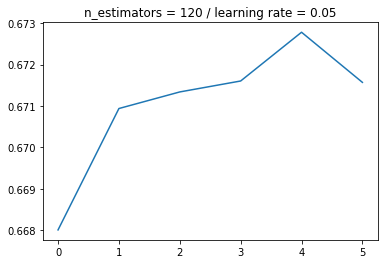

In [87]:
gbc, score = optimize2(n_estimators = n_estimators,
                       learning_rate = learning_rate,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf,
                       max_depth = max_depth,
                       max_features = max_features,
                       subsample = subsample)

In [88]:
score

0.6715707641261119

In [89]:
scores

array([0.66800937, 0.67093953, 0.67133982, 0.67160396, 0.67278057])

In [90]:
# Updating the results
models = np.append(models, gbc)
scores = np.append(scores, score)

In [92]:
#Model 6
'''
Updating learning_rate and n_estimators
'''
learning_rate /= 5
n_estimators *=5

learning_rate, n_estimators

(0.002, 3000)

<h5>As shown at the graph, the score keeps rising. So we are gonna keep updating the variables 'learning_rate' and 'n_estimators'</h5>

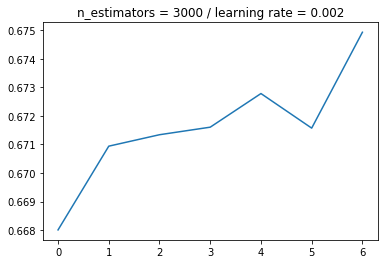

In [93]:
gbc, score = optimize2(n_estimators = n_estimators,
                       learning_rate = learning_rate,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf,
                       max_depth = max_depth,
                       max_features = max_features,
                       subsample = subsample)

In [94]:
# Updating the variables with the results
models = np.append(models, gbc)
scores = np.append(scores, score)

In [95]:
scores

array([0.66800937, 0.67093953, 0.67133982, 0.67160396, 0.67278057,
       0.67157076, 0.6749253 ])

In [96]:
# MODEL 7
learning_rate /= 2
n_estimators *= 2
learning_rate, n_estimators

(0.001, 6000)

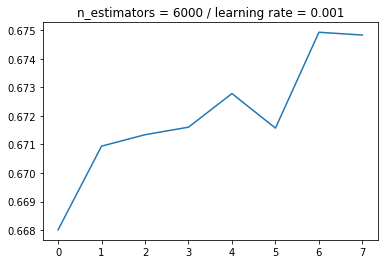

In [97]:
gbc, score = optimize2(n_estimators = n_estimators,
                       learning_rate = learning_rate,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf,
                       max_depth = max_depth,
                       max_features = max_features,
                       subsample = subsample)

In [98]:
# Updating the variables with the results
models = np.append(models, gbc)
scores = np.append(scores, score)

In [99]:
scores

array([0.66800937, 0.67093953, 0.67133982, 0.67160396, 0.67278057,
       0.67157076, 0.6749253 , 0.67482658])

In [100]:
# MODEL 8
learning_rate /= 5
n_estimators *= 5
learning_rate, n_estimators

(0.0002, 30000)

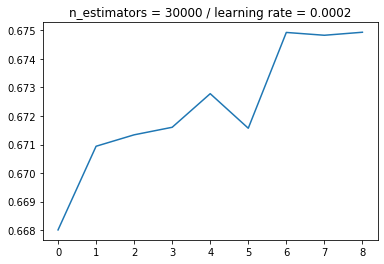

In [101]:
gbc, score = optimize2(n_estimators = n_estimators,
                       learning_rate = learning_rate,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf,
                       max_depth = max_depth,
                       max_features = max_features,
                       subsample = subsample)

In [102]:
# Updating the variables with the results
models = np.append(models, gbc)
scores = np.append(scores, score)

In [103]:
scores

array([0.66800937, 0.67093953, 0.67133982, 0.67160396, 0.67278057,
       0.67157076, 0.6749253 , 0.67482658, 0.67493242])

In [104]:
'''
Here we are printing the model that showed the best score. This model has the best parameters to use in the 
predictive algorithm
'''
print('Modelo de melhor desempenho: ', scores.argmax(), ' - AUC: ', max(scores))

Modelo de melhor desempenho:  8  - AUC:  0.6749324183632107


In [105]:
'''
The variable 'best_model' is receiving the best parameters to the algorithm. That way, we can fit the train datasets
later.
'''

best_model = models[scores.argmax()]

In [106]:
best_model.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
'''
The variable 'y_pred_probs' is receiving a vector with two columns, containing the probabilities for the 
two classes: -1 (not churn) and 1 (churn).
'''
y_pred_probs = best_model.predict_proba(X_test)

In [ ]:
y_pred_probs

In [ ]:
'''
We want the probabilities of churning. So we are going to get all the rows and the second column that contain the 
probabilities to churn.
'''
y_pred_probs[:, 1]

In [ ]:
'''
Here we are testing those probabilities in the test dataset, using the ROC metric. 
'''
roc_auc_score(y_test, y_pred_probs[:, 1])